# Exploratory Data Analysis

When placed in Metapack data package, this notebook will load the package and run a variety of common EDA operations on the first resource. 


In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')


In [2]:
pkg = mp.jupyter.open_package()

# For testing and development
#pkg = mp.open_package('http://s3.amazonaws.com/library.metatab.org/cde.ca.gov-accountability_dashboard-2.zip')

pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-9` Last Update: 2019-10-03T18:22:47

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a
href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless
-Sleepers.png"><img
src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-
Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).

## Base and Imputed Datasets

This distribution has two version of the homeless counts, the base set,
``homeless_counts``, which has three months of missing data, and the imputed
dataset, ``imputed_counts`` in which these three missing months, 2014-08,
2014-09, and 2015-06 are probabilistically re-created.

The Imputation process uses the total count for the month, from the
``monthly_totals`` dataset, as the number of sleepers that the imputed month
will have. Then, the imputation process collects at least 1,000 records with
dates near the missing month into a sample set, calculating the portion of
records that are in each census block. Then the algorithm randomly selects that
number of records for each census block, and adjusts random blocks so the total
of the whole set of selected records is equal to the official count for the
month.

The result is an imputed month that has the same number of records as the
official count for the month and as the same portion of sleepers in each census
block as in adjacent months.

## Notes

Notes for the source dataset, as of April 2019:

The preliminary methodology (shown in yellow) [ March 2017 and earlier] counted
two individuals per tent and two individuals per vehicle.

On April 27, 2017, the Clean & Safe program adopted the counting methodology
used by the Regional Task Force on the Homeless. Per the methodology
(represented above by the dark green cells), [April 2017 to April 2018,
inclusive ] Clean & Safe staff counted 1.75 individuals per visible
tent/structure and 1.66 individuals per vehicle that showed clear signs of
habitation.

In May 2018, the Regional Task Force on the Homeless updated the methodology
for vehicles to 2.03 that shows clear signs of habitation (the methodology of
1.75 individuals per tent/structure remained the same). The Clean & Safe
program implemented this methodology on May 31, 2018 (represented in orange).

\* Denotes the months that The Downtown Fellowship of Ministries and Churches collaborated with us on the monthly homeless sleep count.

\*\*East Village breakout areas include the following:
    * North East East Village is the area north of Market Street & east of Park Ave. 
    * North West is the area north of Market Street & west of Park Ave.
    * South East is the area east of Park Ave. south of Market Street
    * South West is the area west of Park Ave. south of Market Street

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF

In [3]:
resource_name='homeless_counts'

In [4]:
pkg.resource(resource_name)

Header,Type,Description
neighborhood,string,"Neighborhood, from the label on the source map"
date,date,"Date of the observation. Many dates have no know day of month; for these dates, the day of month is set to 1"
type,string,"Type of sleeper: individual, vehicle or structure"
temp,float,"Temperature, if it was written on the source map"
rain,string,"Rain or clear, if it was written on the source map"
geoid,string,"Census geoid for the 2010 Census block the observation is in, in ACS format"
x,number,"X geographic position, in California State Plane 6, EPSG:2230"
y,number,"Y geographic position, in California State Plane 6, EPSG:2230"
geometry,string,"Geographic position of observation, in Lat/Lon, EPSG:4326"


In [5]:
df = pkg.resource(resource_name).read_csv(parse_dates=True)

In [6]:
df.head()

,neighborhood,date,type,temp,rain,geoid,x,y,geometry
0,east_village,2014-01-01,individual,NaN,NaN,10100US060730052002017,6.283584e+06,1.840917e+06,"POLYGON ((-117.153825 32.714699, -117.153815 3..."
1,east_village,2014-01-01,individual,NaN,NaN,10100US060730052002017,6.283584e+06,1.840917e+06,"POLYGON ((-117.153825 32.714699, -117.153815 3..."
2,east_village,2014-01-01,individual,NaN,NaN,10100US060730052002017,6.283584e+06,1.840917e+06,"POLYGON ((-117.153825 32.714699, -117.153815 3..."
3,east_village,2014-01-01,individual,NaN,NaN,10100US060730052002017,6.283584e+06,1.840917e+06,"POLYGON ((-117.153825 32.714699, -117.153815 3..."
4,east_village,2014-01-01,individual,NaN,NaN,10100US060730052002017,6.283584e+06,1.840917e+06,"POLYGON ((-117.153825 32.714699, -117.153815 3..."


In [7]:
empty_col_names = [cn for cn in df.columns if df[cn].nunique() == 0]
const_col_names= [cn for cn in df.columns if df[cn].nunique() == 1]
ignore_cols = empty_col_names+const_col_names
dt_col_names= list(df.select_dtypes(include=[np.datetime64]).columns)

number_col_names = [ cn for cn in df.select_dtypes(include=[np.number]).columns if cn not in ignore_cols ]
other_col_names = [cn for cn in df.columns if cn not in (empty_col_names+const_col_names+dt_col_names+number_col_names)]

In [8]:
pd.DataFrame.from_dict({'empty':[len(empty_col_names)], 
                        'const':[len(const_col_names)],
                        'datetime':[len(dt_col_names)],
                        'number':[len(number_col_names)],
                        'other':[len(other_col_names)],
                       }, 
                       orient='index', columns=['count'])

,count
empty,0
const,0
datetime,1
number,3
other,5


# Constant Columns

In [9]:
if const_col_names:
    display(df[const_col_names].drop_duplicates().T)

# Empty Columns

In [10]:
if empty_col_names:
    display(df[empty_col_names].drop_duplicates().T)

# Date and Time Columns

In [11]:
if dt_col_names:
    display(df[dt_col_names].info())
    display(df[dt_col_names].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 1 columns):
date    39202 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 306.3 KB


None

,count,unique,top,freq,first,last
date,39202,85,2016-12-29 00:00:00,1414,2014-01-01 00:00:00,2018-02-21 00:00:00


# Number Columns

In [12]:
if number_col_names:
    display(df[number_col_names].info())
    display(df[number_col_names].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 3 columns):
temp    14190 non-null float64
x       39202 non-null float64
y       39202 non-null float64
dtypes: float64(3)
memory usage: 918.9 KB


None

,count,mean,std,min,25%,50%,75%,max
temp,14190.0,5.671952e+01,7.238765,4.200000e+01,5.200000e+01,5.800000e+01,6.400000e+01,6.700000e+01
x,39202.0,6.283261e+06,1786.339832,6.278185e+06,6.281792e+06,6.283803e+06,6.284873e+06,6.285441e+06
y,39202.0,1.840108e+06,1463.591121,1.837472e+06,1.838919e+06,1.839708e+06,1.841218e+06,1.844135e+06


## Distributions

In [13]:
def plot_histograms(df):

    col_names = list(df.columns)

    n_cols = np.ceil(np.sqrt(len(col_names)))
    n_rows = np.ceil(np.sqrt(len(col_names)))

    #plt.figure(figsize=(3*n_cols,3*n_rows))
    fig, ax = plt.subplots(figsize=(3*n_cols,3*n_rows))
    
    for i in range(0,len(col_names)):
        plt.subplot(n_rows + 1,n_cols,i+1)
        try:
            g = sns.distplot(df[col_names[i]].dropna(),kde=True) 
            g.set(xticklabels=[])
            g.set(yticklabels=[])
        except:
            pass
        
    plt.tight_layout()
        


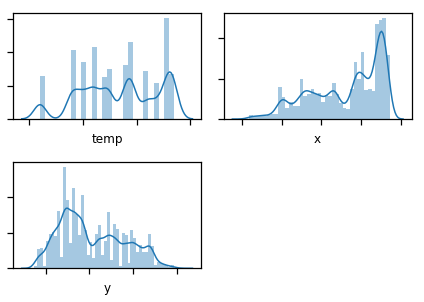

In [14]:
plot_histograms(df[number_col_names])

## Box Plots

In [15]:
def plot_boxes(df):

    col_names = list(df.columns)

    n_cols = np.ceil(np.sqrt(len(col_names)))
    n_rows = np.ceil(np.sqrt(len(col_names)))

    #plt.figure(figsize=(2*n_cols,3*n_rows))
    fig, ax = plt.subplots(figsize=(2*n_cols,5*n_rows))
    
    for i in range(0,len(col_names)):
        plt.subplot(n_rows + 1,n_cols,i+1)
        try:
            g = sns.boxplot(df[col_names[i]].dropna(),orient='v') 
        except:
            pass
        
    plt.tight_layout()
  

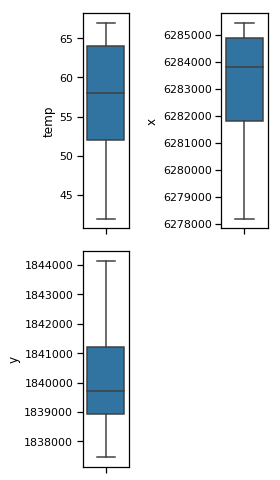

In [16]:
  
plot_boxes(df[number_col_names])

In [17]:
## Correlations

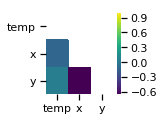

In [18]:

cm = df[number_col_names].corr()

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(.5*len(number_col_names),.5*len(number_col_names)))
sns.heatmap(cm, mask=mask, cmap = 'viridis')   

# Other Columns

In [19]:
if other_col_names:
    display(df[other_col_names].info())
    display(df[other_col_names].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 5 columns):
neighborhood    39202 non-null object
type            39202 non-null object
rain            17119 non-null object
geoid           39202 non-null object
geometry        39202 non-null object
dtypes: object(5)
memory usage: 1.5+ MB


None

,count,unique,top,freq
neighborhood,39202,6,east_village,25522
type,39202,3,individual,37052
rain,17119,2,clear,14827
geoid,39202,287,10100US060730051001013,2297
geometry,39202,287,"POLYGON ((-117.148533 32.706671, -117.148531 3...",2297


# Nulls


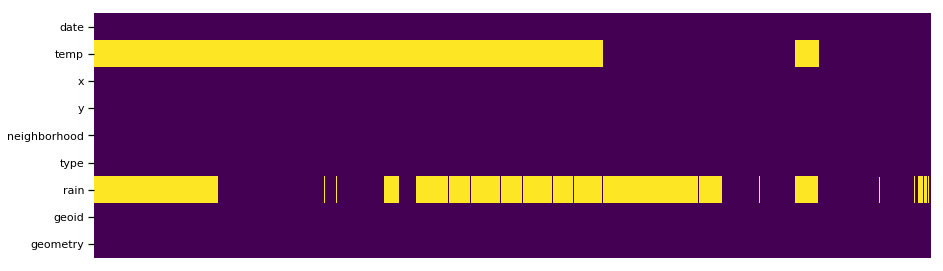

In [20]:
cols = dt_col_names + number_col_names + other_col_names

fig, ax = plt.subplots(figsize=(15,.5*len(cols)))
sns.heatmap(df[cols].isnull().T,cbar=False,xticklabels=False,cmap = 'viridis', ax=ax )